# td3

In [1]:
# == recnn ==
import sys
sys.path.append("../../../")
import recnn

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

tqdm.pandas()

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

/home/dev/.local/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
frame_size = 10
batch_size = 25
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="../../../data/",
    embeddings="embeddings/ml20_pca128.pkl",
    ratings="ml-20m/ratings.csv",
    cache="cache/frame_env.pkl",
    use_cache=True
)
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)

In [3]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = td3.update(batch, learn=False)
    return loss

value1_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
value2_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

cuda = torch.device('cuda')
td3 = recnn.nn.TD3(policy_net, value1_net, value2_net)
td3 = td3.to(cuda)

from time import gmtime, strftime
td3.writer = SummaryWriter(log_dir='../../../runs/td3_{}/'.format(strftime("%m-%d_%H:%M", gmtime())))
plotter = recnn.utils.Plotter(td3.loss_layout, [['value1', 'value2'],['policy']],)

In [12]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2
td3._step = 0

def learn():
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = td3.update(batch, learn=True)
            plotter.log_losses(loss)
            td3.step()
            if td3._step % plot_every == 0:
                clear_output(True)
                print('step', td3._step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if td3._step > 4000: # adjust when it needs to stop
                return
            
learn()

In [9]:
torch.save(td3.nets['policy_net'].state_dict(), '../../../models/td3_policy.model')
torch.save(td3.nets['value_net1'].state_dict(), '../../../models/td3_value1.model')
torch.save(td3.nets['value_net2'].state_dict(), '../../../models/td3_value2.model')

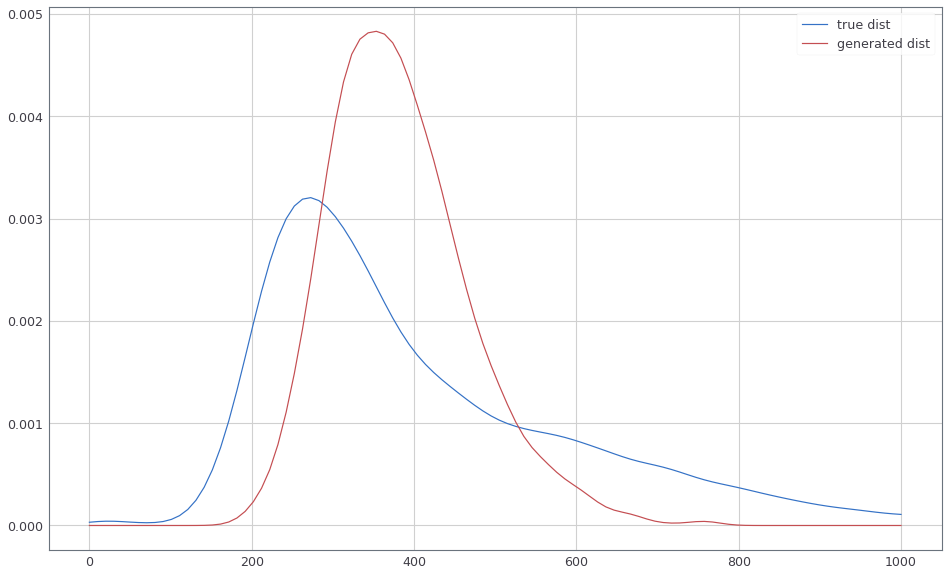

In [11]:
gen_actions = td3.debug['next_action']
true_actions = env.embeddings.numpy()


ad = recnn.nn.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../../models/anomaly.pt'))
ad.eval()

plotter.plot_kde_reconstruction_error(ad, gen_actions, true_actions, cuda)